# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

import sklearn.linear_model
from tqdm import tqdm
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

# 2 Metadata

In [2]:
lev_index = 23
exp_index = 0
exp_name = "cv"

In [3]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name)

In [4]:
train_x_filename = "train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)
valid_x_filename = "valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)

In [23]:
ml_exp_id =1

In [24]:
model_name = "linear_level_{}_experiment_{}".format(lev_index, ml_exp_id)
model_path = os.path.join(config.model_path,exp_name, model_name)

model_plot_path = os.path.join(model_path, "plots")
os.makedirs(model_plot_path, exist_ok=True)

# 3 Load Data

In [5]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [6]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [7]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [8]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))

feature_coords = train_x_xr_stack.feature
sample_coords = train_x_xr_stack.sample

train_x_xr_stack_dropna = train_x_xr_stack.dropna(dim="feature")
valid_x_xr_stack_dropna = valid_x_xr_stack.dropna(dim="feature")

feature_dropna_coords = train_x_xr_stack_dropna.feature

In [9]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


# 5 Model

In [10]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

feature_drop_coords = train_x_xr_stack_dropna.feature
feature_full_coords = train_x_xr_stack.feature 

train_x_ml_xr = train_x_xr_stack_dropna["rho"]
valid_x_ml_xr = valid_x_xr_stack_dropna["rho"]

train_y_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_ml_xr = valid_y_xr_stack["atlantic_moc"]

train_y_true_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_true_ml_xr = valid_y_xr_stack["atlantic_moc"]


In [11]:
def mse_xr(pred, true, sample_dim = "sample"):
    return np.square(pred - true).mean(dim=sample_dim)

## 5.1 Train

In [27]:
alpha_list = np.logspace(-1,5, 100)

In [28]:
train_mse_list = []
valid_mse_list = []


for i,alpha in tqdm(enumerate(alpha_list)): 
    
    model = sklearn.linear_model.Ridge(alpha = alpha)
    
    model.fit(train_x_ml_xr, train_y_ml_xr)
    
    model_coef_ml_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_drop_coords} )
    model_coef_tmp,_ = xr.align(model_coef_ml_xr, feature_coords, join="outer")

    train_y_pred_ml_np = model.predict(train_x_ml_xr)
    valid_y_pred_ml_np = model.predict(valid_x_ml_xr)

    train_y_pred_ml_xr = xr.DataArray(train_y_pred_ml_np, dims= ["sample"], coords = {"sample": train_sample_coords, "alpha":alpha})
    valid_y_pred_ml_xr = xr.DataArray(valid_y_pred_ml_np, dims= ["sample"], coords = {"sample": valid_sample_coords, "alpha":alpha})


    train_mse_tmp = mse_xr(train_y_pred_ml_xr, train_y_true_ml_xr)
    valid_mse_tmp = mse_xr(valid_y_pred_ml_xr, valid_y_true_ml_xr)


    model_name = "model_{}.sav".format(i)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    
    if i == 0: 
        model_coef = model_coef_tmp.assign_coords({"alpha": alpha})
        train_mse = train_mse_tmp.assign_coords({"alpha":alpha})
        valid_mse = valid_mse_tmp.assign_coords({"alpha":alpha})
        train_pred = train_y_pred_ml_xr.assign_coords({"alpha":alpha})
        valid_pred = valid_y_pred_ml_xr.assign_coords({"alpha":alpha})

    else:
        model_coef = xr.concat([model_coef, model_coef_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_mse = xr.concat([train_mse, train_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        valid_mse = xr.concat([valid_mse, valid_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_pred = xr.concat([train_pred, train_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        valid_pred = xr.concat([valid_pred, valid_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        

    data = xr.merge([
        model_coef.rename("coefficients"),
        train_mse.rename("train_mse"), 
        valid_mse.rename("valid_mse"),
        valid_pred.rename("valid_pred"),
        train_pred.rename("train_pred"),
        ])


0it [00:00, ?it/s]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.55188e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
1it [00:03,  3.49s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.79368e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
2it [00:06,  3.10s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.07315e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
3it [00:09,  2.93s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.

## 5.2  Evaluation

In [33]:
diff = data["train_mse"] - data["valid_mse"]

In [34]:
train_corr = xr.corr(train_y_true_ml_xr, data["train_pred"], dim="sample")
valid_corr = xr.corr(valid_y_true_ml_xr, data["valid_pred"], dim="sample")


In [35]:
alpha_min_diff = data.alpha.isel(alpha = (np.abs(diff).argmin()))
alpha_min_val  = data.alpha.isel(alpha = data["valid_mse"].argmin())
alpha_min = data.alpha.min()
alpha_max = data.alpha.max()


Text(112.59722222222221, 0.5, 'Error')

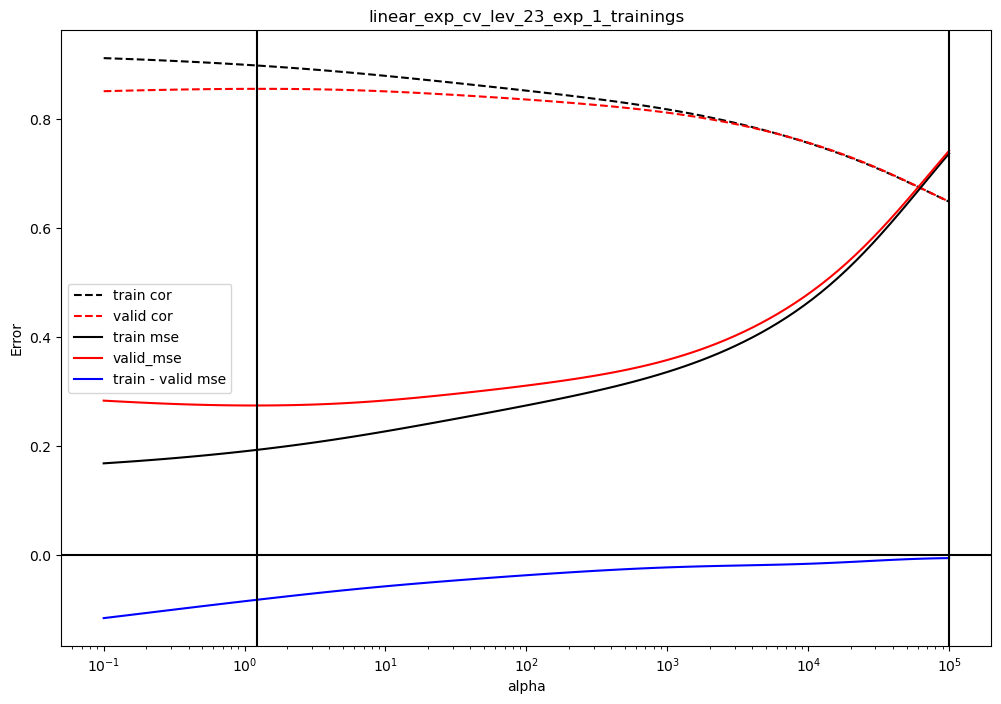

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(data.alpha, train_corr, color="black", linestyle="dashed", label="train cor")
plt.plot(data.alpha, valid_corr, color="red", linestyle="dashed", label="valid cor")
plt.plot(data.alpha, data["train_mse"], color="black", label="train mse")
plt.plot(data.alpha, data["valid_mse"], color="red",   label="valid_mse")
plt.plot(data.alpha, diff, color="blue", label="train - valid mse")
plt.xscale("log")

plt.axhline(0, color="black")
plt.axvline(alpha_min_diff.values.item(), color="black")
plt.axvline(alpha_min_val.values.item(), color="black")


plt.legend()

name = "linear_exp_{}_lev_{}_exp_{}_trainings".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))
plt.xlabel("alpha")
plt.ylabel("Error")


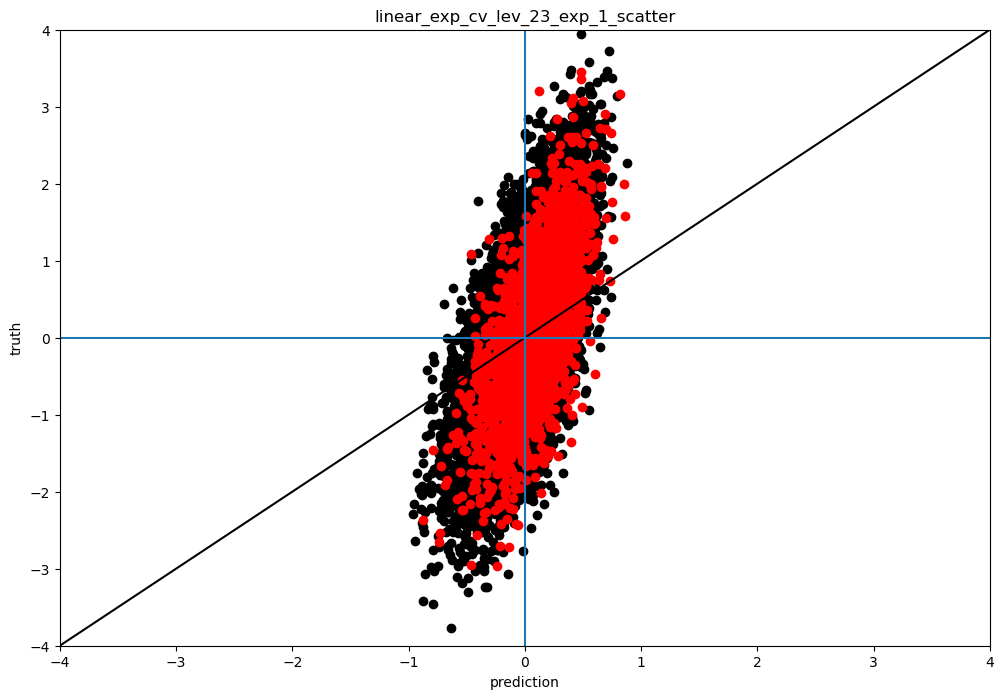

In [47]:

fig, ax = plt.subplots(figsize=(12,8))

plt.xlim(-4,4)
plt.ylim(-4,4)

plt.scatter(data["train_pred"].sel(alpha=alpha_min_diff).dropna(dim="sample", how="all"), train_y_true_ml_xr, color="black")
plt.scatter(data["valid_pred"].sel(alpha=alpha_min_diff).dropna(dim="sample", how="all"), valid_y_true_ml_xr, color="red")

x = np.arange(-4,5)


plt.plot(x,x, color="black")
plt.axhline(0)
plt.axvline(0)

plt.xlabel("prediction")
plt.ylabel("truth")

name = "linear_exp_{}_lev_{}_exp_{}_scatter".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))



In [38]:
coefficients = data["coefficients"].unstack()

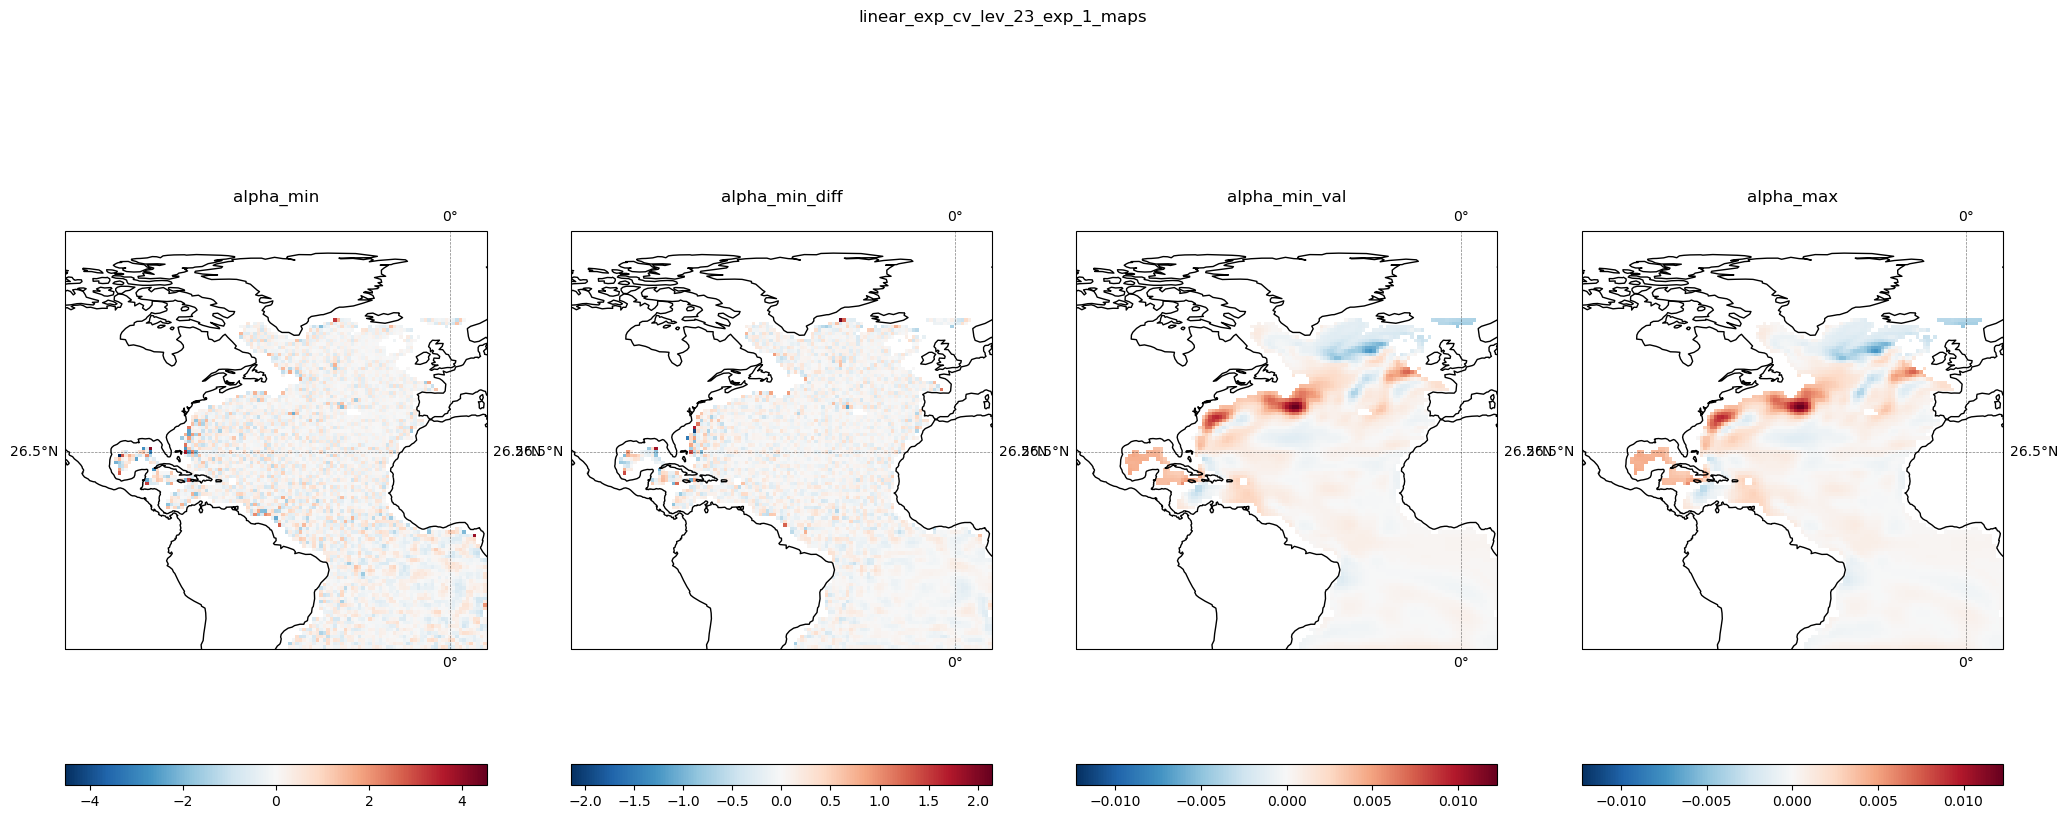

In [49]:
fig, ax  = plt.subplots(1,4,figsize=(25,10), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)


tmp = coefficients.sel(alpha=alpha_min, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[0].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax= vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[0], orientation="horizontal")


tmp = coefficients.sel(alpha=alpha_min_val, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[1].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[1], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_min_diff, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[2].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[2], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_max, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[3].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[3], orientation="horizontal")


ax[0].set_title("alpha_min")
ax[1].set_title("alpha_min_diff")
ax[2].set_title("alpha_min_val")
ax[3].set_title("alpha_max")

for i, ax in enumerate(ax_ravel):
    ax.coastlines()
    ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

name = "linear_exp_{}_lev_{}_exp_{}_maps".format(exp_name, lev_index, ml_exp_id )
fig.suptitle(name)
plt.savefig(os.path.join(model_plot_path, name))



In [41]:
data_valid_pred_year = data["valid_pred"].unstack().assign_coords({"time":data["valid_pred"].unstack().time.dt.year}).dropna(dim="time", how="all")
data_train_pred_year = data["train_pred"].unstack().assign_coords({"time":data["train_pred"].unstack().time.dt.year}).dropna(dim="time", how="all")

In [42]:
data_valid_true_year = valid_y_true_ml_xr.unstack().assign_coords({"time":valid_y_true_ml_xr.unstack().time.dt.year})
data_train_true_year = train_y_true_ml_xr.unstack().assign_coords({"time":train_y_true_ml_xr.unstack().time.dt.year})

In [43]:
valid_pred_polyfit = data_valid_pred_year.polyfit(deg=1, dim="time")
train_pred_polyfit = data_train_pred_year.polyfit(deg=1, dim="time")

valid_true_polyfit = data_valid_true_year.polyfit(deg=1, dim="time")
train_true_polyfit = data_train_true_year.polyfit(deg=1, dim="time")

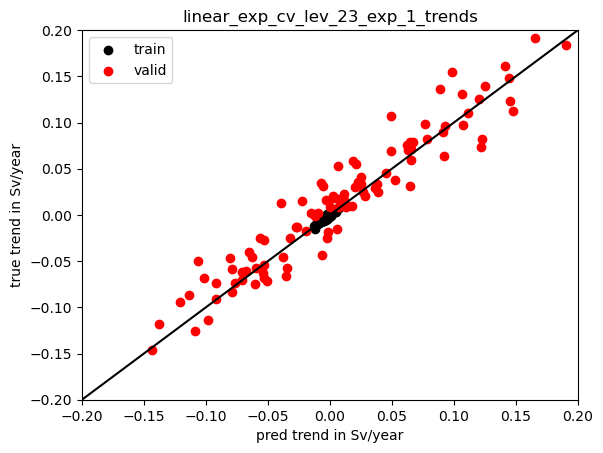

In [44]:
plt.scatter(train_pred_polyfit["polyfit_coefficients"].isel(degree=0).sel(alpha=alpha_min_val), train_true_polyfit["polyfit_coefficients"].isel(degree=0), color="black", label="train")
plt.scatter(valid_pred_polyfit["polyfit_coefficients"].isel(degree=0).sel(alpha=alpha_min_val), valid_true_polyfit["polyfit_coefficients"].isel(degree=0), color="red", label="valid")


plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

x = np.arange(-2,2)

plt.plot(x,x, color="black")


plt.xlabel("pred trend in Sv/year")
plt.ylabel("true trend in Sv/year")

plt.legend()
name = "linear_exp_{}_lev_{}_exp_{}_trends".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))

